In [44]:
import cv2
import numpy as np
from scipy.spatial import distance
from matplotlib import pyplot as plt
from scipy.interpolate import griddata


In [45]:
def convert_to_LAB_and_back(image):
    """Коррекция изображения через преобразование в LAB и обратно."""
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab_image)
    corrected_lab_image = cv2.merge([l, a, b])
    corrected_rgb_image = cv2.cvtColor(corrected_lab_image, cv2.COLOR_Lab2BGR)
    return corrected_rgb_image


In [46]:
def find_nearest_samples(sample_color, test_samples):
    """Поиск ближайших образцов по цвету."""
    closest_samples = sorted(test_samples.keys(), key=lambda color: distance.euclidean(color, sample_color))
    return closest_samples[:2]


In [47]:
def interpolate(color, color1, ph1, color2, ph2):
    """Интерполяция для оценки pH."""
    color = np.array(color)
    color1 = np.array(color1)
    color2 = np.array(color2)
    if np.array_equal(color, color1): return ph1
    if np.array_equal(color, color2): return ph2
    weight1 = 1 / np.linalg.norm(color - color1) if not np.array_equal(color, color1) else 0
    weight2 = 1 / np.linalg.norm(color - color2) if not np.array_equal(color, color2) else 0
    return (ph1 * weight1 + ph2 * weight2) / (weight1 + weight2) if weight1 + weight2 else np.nan


In [48]:
# Загрузка и коррекция изображения
image_path = 'image/6.0.png'
image = cv2.imread(image_path)
image_corrected = convert_to_LAB_and_back(image)

In [49]:
# Обнаружение кругов
gray = cv2.cvtColor(image_corrected, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (9, 9), 0)
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=20, maxRadius=200)


Средний цвет центральной части круга: (207.25751485989244, 233.87279932069063, 240.63719218794228)


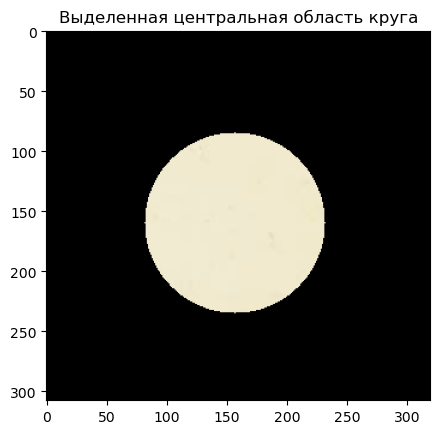

Оценочное значение pH: 5.7


In [50]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        x, y, r = circle[0], circle[1], circle[2]

        mask = np.zeros(gray.shape, dtype="uint8")
        cv2.circle(mask, (x, y), r // 2, 255, -1)

        mean_val = cv2.mean(image_corrected, mask=mask)[:3]
        print("Средний цвет центральной части круга:", mean_val)

        masked_image = cv2.bitwise_and(image_corrected, image_corrected, mask=mask)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.title('Выделенная центральная область круга')
        plt.show()
else:
    print("Круги не обнаружены.")


test_samples = {
    (235, 223, 204): 8.0,
    (232, 217, 192): 7.7,
    (222, 221, 193): 7.5,
    (222, 226, 221): 7.2,
    (228, 234, 236): 6.9,
    (236, 232, 215): 6.5,
    (220, 235, 239): 6.3,
    (207, 234, 240): 6.0,
    (174, 234, 242): 5.7,
}

if mean_color is not None:
    points = np.array(list(test_samples.keys()))
    values = np.array(list(test_samples.values()))
    estimated_ph = griddata(points, values, [mean_color], method='nearest')[0]
    print("Оценочное значение pH:", estimated_ph)
else:
    print("Невозможно оценить pH: нет среднего цвета.")

Круги не обнаружены.
